In order to deal with the proposed challenge, the first step was to test the segmentation performances of the template network provided in the ANN labs with images whose sized have been progressively downscaled from 1024x1024 (size A) to 256x512 (size B), through 256x256 (size C).
During the process, two main problems that required a reflection arose: (1) training on very size (A and B ) images resulted very time and resource consuming;  and (2) decreasing too much the size of the images (for BipBip Haricot images the reduction ratio was 6 and 8 for height and width respectively if we consider a starting size of 2048x1536 and 256x256 as end) produced a very strong decrease in the network accuracy, probably due to the information losses caused by the multiple resizing  (enlarging and shrinking) involved in the images downscaling and upscaling.
In order to overcome computational time and accuracy issues, we developed a three-step reconstructing-prediction method (TSRP). TSRP firstly splits each image into different patches and then it trains a network onto the collection of patches themselves. Then, in order to obtain a full-sized image, it performs a reconstruction step by combining the patches. The backbone network chosen was a VGG19 since a more deeper network with respect to VGG16 seemed more suitable for this task as allowed for the creation of feature maps of deeper level.
Also an approach combining A VGG16 architecture with a U-Net,producing a Ternaus like architecture, ( see the corresponding .ipynb) has been tried in order to exploit all the advantages of skip connetions and properly segment also very small details.
In order to produce a more readable and easily modifiable script, we created a set of classes that allowed us to build a smooth neural network pipeline, from model definition to testing. In addition, to simply the creation of models, we exploited a public repository that contains several backbone models for image segmentation.
Here an example of the main script:

```python
img_w = 256
img_h = 256

models_string = ['inceptionv3', 'senet154', 'vgg16']

models = []
preproc_fs = []

for model_string in models_string:
    models.append(
        sm.Unet(model_string, classes=3, activation='softmax', input_shape=(img_h, img_w, 3), encoder_weights=None)
    )
    preproc_fs.append(sm.get_preprocessing(model_string))

firstTentative = NeuralNetworkFlow(seed=1996,
                                   n_classes=3,
                                   out_h=img_h, out_w=img_w, img_h=img_h, img_w=img_w,
                                   batch_size=32,
                                   n_test_images=15
                                   )

firstTentative.apply_data_augmentation()

for i in range(len(models)):
    firstTentative.create_train_validation_sets(preprocessing_function=preproc_fs[i], use_data_aug_test_time=True)
    firstTentative.set_neural_network_model(models[i], firstTentative.create_callbacks(model_name=models_string[i],
                                                                                       save_weights_only=True,
                                                                                       monitor='val_meanIoU'),
                                            epochs=100,
                                            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                                            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                            metrics=[firstTentative.meanIoU, 'accuracy']
                                            )
    firstTentative.train_models()
```
In the end, we selected as the best approach the one that exploits TSRP because we observed that this approach produce the best performing model on the validation set.
To check how we design all our attempts please check -> https://github.com/nicologhielmetti/AN2DL-challenges/tree/master/challenge2


<a href="https://colab.research.google.com/github/nicologhielmetti/AN2DL-challenges/blob/master/challenge2/Colab_Notebooks/Chall2_Multiclass_Segm_patched.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
#Just the first time in order to retrieve the images to be patched and the correct name of the images
#to be used later.
!gdown https://drive.google.com/uc?id=1iJ3O6mZduuaf_97eszLzVLyU5SaLvBE1
!unzip /content/Development_Dataset.zip

In [ ]:
#Patched images
!gdown https://drive.google.com/uc?id=1lFfDcDvnPhZsHByjc1KauyEbydN22sN3
!unzip /content/Develpment.zip

In [ ]:
#Weights
!gdown https://drive.google.com/uc?id=10KlUQO8k52sC289NspW4ROUa2Z5f5P2W
!gdown https://drive.google.com/uc?id=10S1XjiEPDbB88_ZnddMr131CI2cwf5uQ

Downloading...
From: https://drive.google.com/uc?id=10KlUQO8k52sC289NspW4ROUa2Z5f5P2W
To: /content/cp_20.ckpt.data-00000-of-00001
258MB [00:01, 231MB/s]
Downloading...
From: https://drive.google.com/uc?id=10S1XjiEPDbB88_ZnddMr131CI2cwf5uQ
To: /content/cp_20.ckpt.index
100% 9.21k/9.21k [00:00<00:00, 7.29MB/s]


In [ ]:
import os
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input 
import time
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from torch.nn import functional as f
import torch
import cv2
import math
import json


SEED = 1234
tf.random.set_seed(SEED)  

In [ ]:
cwd = os.getcwd()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def read_rgb_mask(img_path):
    '''
    img_path: path to the mask file
    Returns the numpy array containing target values
    '''

    mask_img = Image.open(img_path)
    mask_arr = np.array(mask_img)
  
    new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0
    new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1
    new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2
    
    return new_mask_arr

In [ ]:
# ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
    mask_data_gen = ImageDataGenerator(rotation_range=10,
                                       width_shift_range=10,
                                       height_shift_range=10,
                                       zoom_range=0.3,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       fill_mode='reflect')

In [ ]:

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [ ]:
test_path_temp = '/content/Development_Dataset/Test_Dev/Bipbip/Haricot/Images' 
test_elements_temp = getListOfFiles(test_path_temp)

In [ ]:
# Patching
# The following eight scripts have been used in order to properly fill the folders with patched images of the images themselves, 
# the masks and to fill the txt used in performing data augmentation. All the initial images are retrieved from Development_Dataset.
# Do not execute them
# Build up the forder of test img patched
def patcher (image):   
  img = cv2.imread(image) 
  name = os.path.basename(image)
  name = name[:len(name)-4]
  img_shape = img.shape
  tile_size = (256, 256)
  offset = (256, 256)
  for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Test_Dev/" + name + "_" + str(i) + "_" + str(j) + '.jpg' , cropped_img)
          
  

In [ ]:
patch_test_img = False
if patch_test_img:
  for k in range(len(test_elements_temp)): 
    patched_img = patcher(test_elements_temp[k])

In [ ]:
#Put the patched images into the folders. Here is shown how the folder unzipped in the second script has been created
redo_folders = False 

images = getListOfFiles("Development_Dataset/Images")
masks =  getListOfFiles("Development_Dataset/Masks")
if (redo_folders):
  patched_img = []
  patched_masks = []
  tile_size = (256, 256)
  offset = (256, 256)
  for image in images:
    img = cv2.imread(image) 
    img_shape = img.shape
    name = os.path.basename(image)
    name = name[:len(name)-4]
    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Images/"+  name + "_" + str(i) + "_" + str(j) + '.jpg', cropped_img)
  for mask in masks:
    img = cv2.imread(mask) 
    img_shape = img.shape
    name = os.path.basename(mask)
    name = name[:len(name)-4]
    for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          cv2.imwrite("/content/drive/My Drive/Develpment/Masks/" + name + "_" + str(i) + "_" + str(j) + '.png' , cropped_img)



In [ ]:
#Fill the train and validation txt 
fill = False
if fill:
  img_names = getListOfFiles("/content/drive/My Drive/Develpment/Images")
  bound = 3352  #equals to 70 images
  count = 0
  train_img = []
  val_img = []
  for image in img_names:
    name = os.path.basename(image)
    name = name[:len(name)-4]
    if (count < bound ):
      train_img.append(name)
      train_img.append(" \n")
    else:
      val_img.append(name)
      val_img.append(" \n")
    count = count+1


In [ ]:
#val_file = open("/content/drive/My Drive/Develpment/Splits/val.txt","w")
#val_file.writelines(val_img)

In [ ]:
#train_file = open("/content/drive/My Drive/Develpment/Splits/train.txt","w")
#train_file.writelines(train_img)

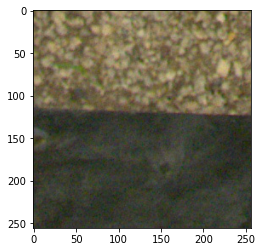

In [ ]:
#first patching technique - Example on one specific image 
patching_test1 = False
if (patching_test1):
  from sklearn.feature_extraction import image
  from torch.nn import functional as f
  import torch
  one_img =Image.open("Development_Dataset/Images/Bipbip_haricot_im_06481.jpg")
  one_img = np.array(one_img)
  tensor = torch.tensor(one_img)
  patches = tensor.unfold(0, 256, 256).unfold(1, 256, 256).unfold(2, 3, 3)
  list_of_patches = []
  ratio_1 = 8
  ratio_2 = 6
  for x in range(ratio_2):
      for y in range(ratio_1):
        list_of_patches.append(np.array(patches[x][y][0]))

  fig, ax = plt.subplots(1, 1)
  patche= patches[5][2][0]
  patche = np.array(patche)
  ax.imshow(np.uint8(patche))
  plt.show()

  #re = patches.permute(0, 3, 1, 4, 2, 5).contiguous().view_as(tensor)
  #print((re == tensor).all())




48

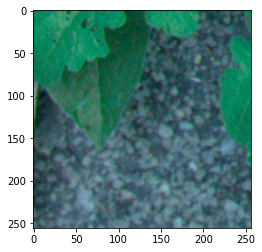

In [ ]:
#Second patching technique - Example on one specific image
patching_test2 = False
if (patching_test2):
  img = cv2.imread("Development_Dataset/Images/Bipbip_haricot_im_06481.jpg") 
  img_shape = img.shape
  tile_size = (256, 256)
  offset = (256, 256)
  lista = []
  for i in range(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in range(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          lista.append(cropped_img)
  fig, ax = plt.subplots(1, 1)
  len(np.array(lista))
  patche = np.array(lista[33])
  ax.imshow(np.uint8(patche))
  plt.show()

In [ ]:
class CustomDataset(tf.keras.utils.Sequence):


  def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
               preprocessing_function=None, out_shape=[ 256,256]):
    if which_subset == 'training':
      subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
    elif which_subset == 'validation':
      subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
    with open(subset_file, 'r') as f:
      lines = f.readlines()
    
    subset_filenames = []
    for line in lines:
      subset_filenames.append(line.strip()) 

    self.which_subset = which_subset
    self.dataset_dir = dataset_dir
    self.subset_filenames = subset_filenames
    self.img_generator = img_generator
    self.mask_generator = mask_generator
    self.preprocessing_function = preprocessing_function
    self.out_shape = out_shape

  def __len__(self):
    return len(self.subset_filenames)

  def __getitem__(self, index):

    # Read Image 
    curr_filename = self.subset_filenames[index]
    img = Image.open(os.path.join(self.dataset_dir, 'Images', curr_filename + '.jpg'))
    mask = read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))
    
    
    # Resize image and mask 

    img = img.resize(self.out_shape)
    
    img_arr = np.array(img)

    mask_arr = np.array(mask)

    # in this dataset 255 mask label is assigned to an additional class, which corresponds to the contours of the objects. We remove it for simplicity.
    
    mask_arr[mask_arr == 255] = 0  

    mask_arr = np.expand_dims(mask_arr, -1)

    if self.which_subset == 'training':
      if self.img_generator is not None and self.mask_generator is not None:
        img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
        mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
        img_arr = self.img_generator.apply_transform(img_arr, img_t)
        out_mask = np.zeros_like(mask_arr)
        for c in np.unique(mask_arr):
          if c > 0:
            curr_class_arr = np.float32(mask_arr == c)
            curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
            curr_class_arr = np.uint8(curr_class_arr)
            curr_class_arr = curr_class_arr * c 
            out_mask += curr_class_arr
    else:
      out_mask = mask_arr
    
    if self.preprocessing_function is not None:
        img_arr = self.preprocessing_function(img_arr)

    return img_arr, np.float32(out_mask)

In [ ]:
img_h = 256
img_w = 256
dataset = CustomDataset('/content/Develpment', 'training', 
                        img_generator=img_data_gen, mask_generator=mask_data_gen)
dataset_valid = CustomDataset('/content/Develpment', 'validation')

In [ ]:
bs = 16
train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w,3], [img_h, img_w,1]))

train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([img_h, img_w, 3], [img_h, img_w, 1]))
valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [ ]:
#Test data generator

%matplotlib inline

# Assign a color to each class

evenly_spaced_interval = np.linspace(0, 1, 20)

colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(train_dataset)

TensorShape([256, 256, 3])

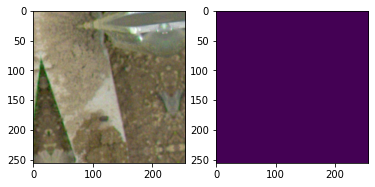

In [ ]:
fig, ax = plt.subplots(1, 2)

augmented_img, target = next(iterator)
augmented_img = augmented_img[0]   
augmented_img = augmented_img   
augmented_img.shape

target = np.array(target[0, ..., 0])  

target_img = np.zeros([target.shape[0], target.shape[1], 3])

target_img[np.where(target == 0)] = [0, 0, 0]
for i in range(0,3):
  target_img[np.where(target == i)] = np.array(colors[i-1])[:3] * 255

ax[0].imshow(np.uint8(augmented_img))
ax[1].imshow(np.uint8(target))

plt.show()



In [ ]:
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
vgg.summary()
#Deeper network wrt VGG16 used in labs

finetuning = True

if finetuning:
    freeze_until = 5 # layer from which we want to fine-tune
    
    for layer in vgg.layers[:freeze_until]:
        layer.trainable = False
else:
    vgg.trainable = False

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
______________________________________________________________

In [ ]:
# Template model - Ann Labs
def create_model(depth, start_f, num_classes):

    model = tf.keras.Sequential()
    
    # Encoder
    
    model.add(vgg)
    
    start_f = 256
        
    # Decoder
   
    for i in range(depth):
        model.add(tf.keras.layers.UpSampling2D(2, interpolation='bilinear'))
        model.add(tf.keras.layers.Conv2D(filters=start_f,
                                         kernel_size=(3, 3),
                                         strides=(1, 1),
                                         padding='same'))
        model.add(tf.keras.layers.ReLU())

        start_f = start_f // 2

    # Prediction Layer
    
    model.add(tf.keras.layers.Conv2D(filters=num_classes,
                                     kernel_size=(1, 1),
                                     strides=(1, 1),
                                     padding='same',
                                     activation='softmax'))
    
    return model

In [ ]:
# Template model - Ann Labs
model = create_model(depth=5, 
                     start_f=8, 
                     num_classes=3)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       1179904   
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       295040    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 32, 128)       0

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy() 
lr = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

def meanIoU(y_true, y_pred):
    
    y_pred = tf.expand_dims(tf.argmax(y_pred, -1), -1)

    per_class_iou = []

    for i in range(0,3): 
      
      class_pred = tf.cast(tf.where(y_pred == i, 1, 0), tf.float32)
      class_true = tf.cast(tf.where(y_true == i, 1, 0), tf.float32)
      intersection = tf.reduce_sum(class_true * class_pred)
      union = tf.reduce_sum(class_true) + tf.reduce_sum(class_pred) - intersection
    
      iou = (intersection + 1e-7) / (union + 1e-7)
      per_class_iou.append(iou)

    return tf.reduce_mean(per_class_iou)

# Validation metrics

metrics = ['accuracy', meanIoU]


# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [ ]:
train = False
if (train):
  

  cwd = os.getcwd()

  exps_dir = os.path.join(cwd, 'drive/MyDrive/Keras4/', 'multiclass_segmentation_experiments')
  if not os.path.exists(exps_dir):
     os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  model_name = 'CNN'

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
  callbacks = []


  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                  save_best_only=True, save_weights_only=True)  
  callbacks.append(ckpt_callback)



  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    

  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  
  callbacks.append(tb_callback)

# Early Stopping

  early_stop = True
  if early_stop:
      es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights= True)
      callbacks.append(es_callback)


  model.fit(x=train_dataset,
          epochs=100,  
          steps_per_epoch=len(dataset)/bs,
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, 
          callbacks=callbacks)



In [ ]:
model.load_weights(os.getcwd()+ '/cp_20.ckpt')

In [ ]:
#model.load_weights('/content/drive/My Drive/Keras4/multiclass_segmentation_experiments/CNN_Dec17_13-02-33/ckpts/cp_20.ckpt')

In [ ]:
#Prepare Submission
def rle_encode(img):
    ''' img: numpy array, 1 - foreground, 0 - background.Returns run length as string formatted'''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
#Retrieve the patched test images
test_path = '/content/Develpment/Test_Dev' 
test_elements = getListOfFiles(test_path)

In [ ]:
def compute_prediction(list_of_pathces):        #general function used for computing a prediction for each patch[to be assembled later]

  predictions_single_img = []
  for patch in list_of_pathces:
    patch = tf.expand_dims(patch, 0)
    out_sigmoid = model.predict(patch)
    predicted_mask = tf.argmax(out_sigmoid, -1)               #masks
    mask_arr = np.array(predicted_mask) 
    mask_arr = tf.squeeze(mask_arr)                    #converted
    predictions_single_img.append(np.array(mask_arr)) 

  return predictions_single_img

In [ ]:
#Reordering the list of patched images
final_list = []  #list of all the 15 global prediction
base = 8 

for i in range(len(test_elements_temp)):
  im = test_elements_temp[i]
  name = os.path.basename(im)
  name = name[:len(name)-4]
  patch_collection = []       #48 patch per image
  for i in range(6):          #retrieve all the patch for one image
    for j in range(8):
      path = "/content/Develpment/Test_Dev/" + name + "_" + str(i) + "_" + str(j) + '.jpg'
      
      img = cv2.imread(path)                 
      patch_collection.append(img)
  pred_collection = compute_prediction(patch_collection )
  ##reconstruction
  oriz_patches = []
  for u in range(6): #first element of the row
    total = pred_collection[u*base]
    for i in range(1,8):   #all other seven
      total = np.concatenate((total, pred_collection[i+u*base]),axis = 1)
    oriz_patches.append(total)
  #build all the 6 horizontal blocks together
  total = oriz_patches[0] 
  for k in range(1,6):
    total = np.concatenate((total, oriz_patches[k]),axis = 0)
  final_list.append(total)
  

In [ ]:
len(final_list)

15

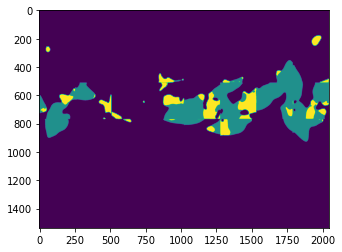

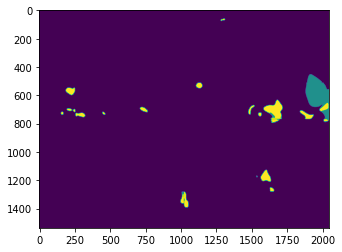

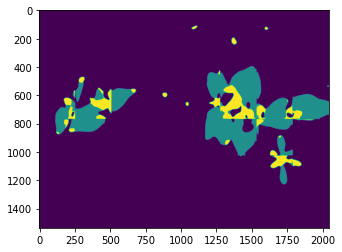

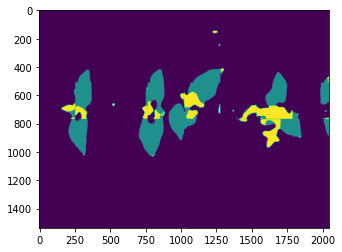

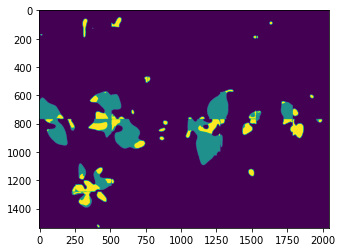

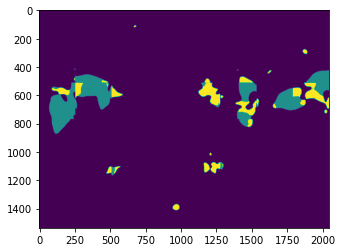

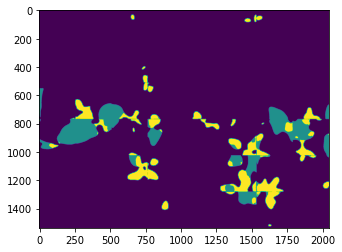

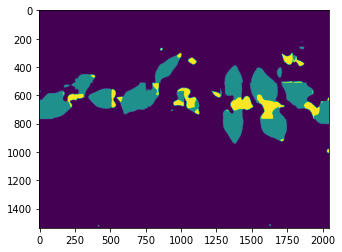

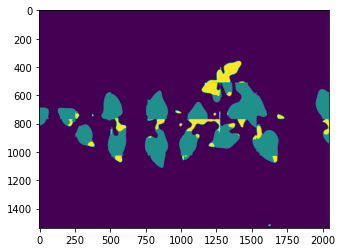

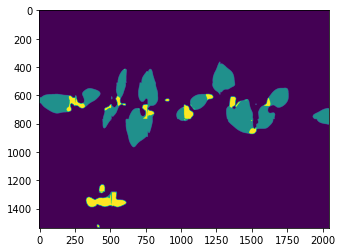

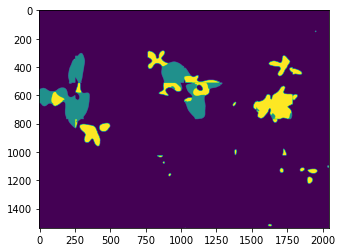

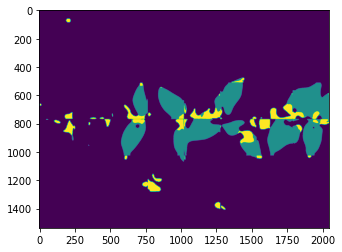

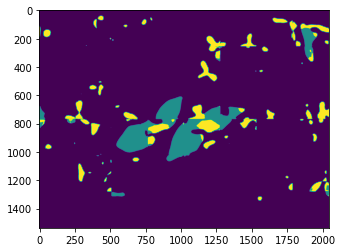

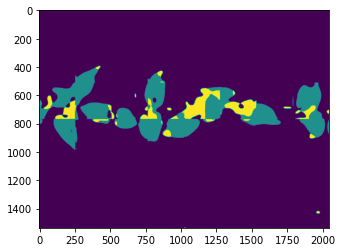

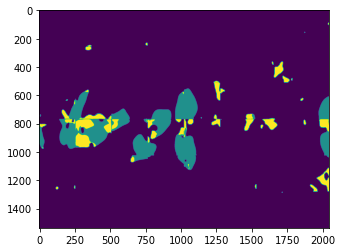

In [ ]:
for el in final_list:
  fig, ax = plt.subplots(1, 1)
  ax.imshow(np.uint8(el))
  plt.show()

In [ ]:
predictions = final_list
for i in range(len(predictions)):
  pred = predictions[i]
  predictions[i] = np.array(pred) 

In [ ]:
#Test_Dev is just a file containing all the other names in order to build up the json
!gdown https://drive.google.com/uc?id=17GZHCD4QDvRItngD-MRmNXOwgI5rU_9A
!unzip /content/Test_Dev.zip

In [ ]:
teams = ["Bipbip","Pead","Roseau","Weedelec"]
crops = ["Haricot","Mais"]

In [ ]:
submission_dict = {}
i = 0
  #we perform the predictions only with a dataset, for the others it is required to put empty string for the submission
                          # Prediction dataset --> Haricot, Bipbip
for team in teams:
  for crop in crops:
    if ((team == "Bipbip") and (crop == "Haricot") ):
      for el in test_elements_temp:      #create all the keys, this might be redoundant code
        img_path = el
        img_name = os.path.basename(img_path)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
      for _id in predictions:        #Adding information for keys that matches the value
          img_path = test_elements_temp[i]
          i = i+1
          img_name = os.path.basename(img_path)
          img_name = img_name[:len(img_name)-4]
          submission_dict[img_name]['shape'] = _id.shape
          submission_dict[img_name]['team'] = team
          submission_dict[img_name]['crop'] = crop
          submission_dict[img_name]['segmentation'] = {}
          rle_encoded_crop = rle_encode(_id == 1)
          rle_encoded_weed = rle_encode(_id == 2)
          submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
          submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed
    
    else:
      img_path = '/content/Test_Dev/'
      img_list = getListOfFiles(img_path + str(team) +'/' + str(crop) + '/Images')
      for img in img_list:     
        img_name = os.path.basename(img)
        img_name = img_name[:len(img_name)-4]
        submission_dict[img_name] = {}
        submission_dict[img_name]['shape'] = (2048,1536)
        submission_dict[img_name]['team'] = team
        submission_dict[img_name]['crop'] = crop
        submission_dict[img_name]['segmentation'] = {}
        submission_dict[img_name]['segmentation']['crop'] = ""
        submission_dict[img_name]['segmentation']['weed'] = ""

In [ ]:

with open('submission.json', 'w') as f:   #dumps the dictionary into the json
  json.dump(submission_dict, f)

In [ ]:
submission_dict

In [ ]:
from google.colab import files
files.download('submission.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

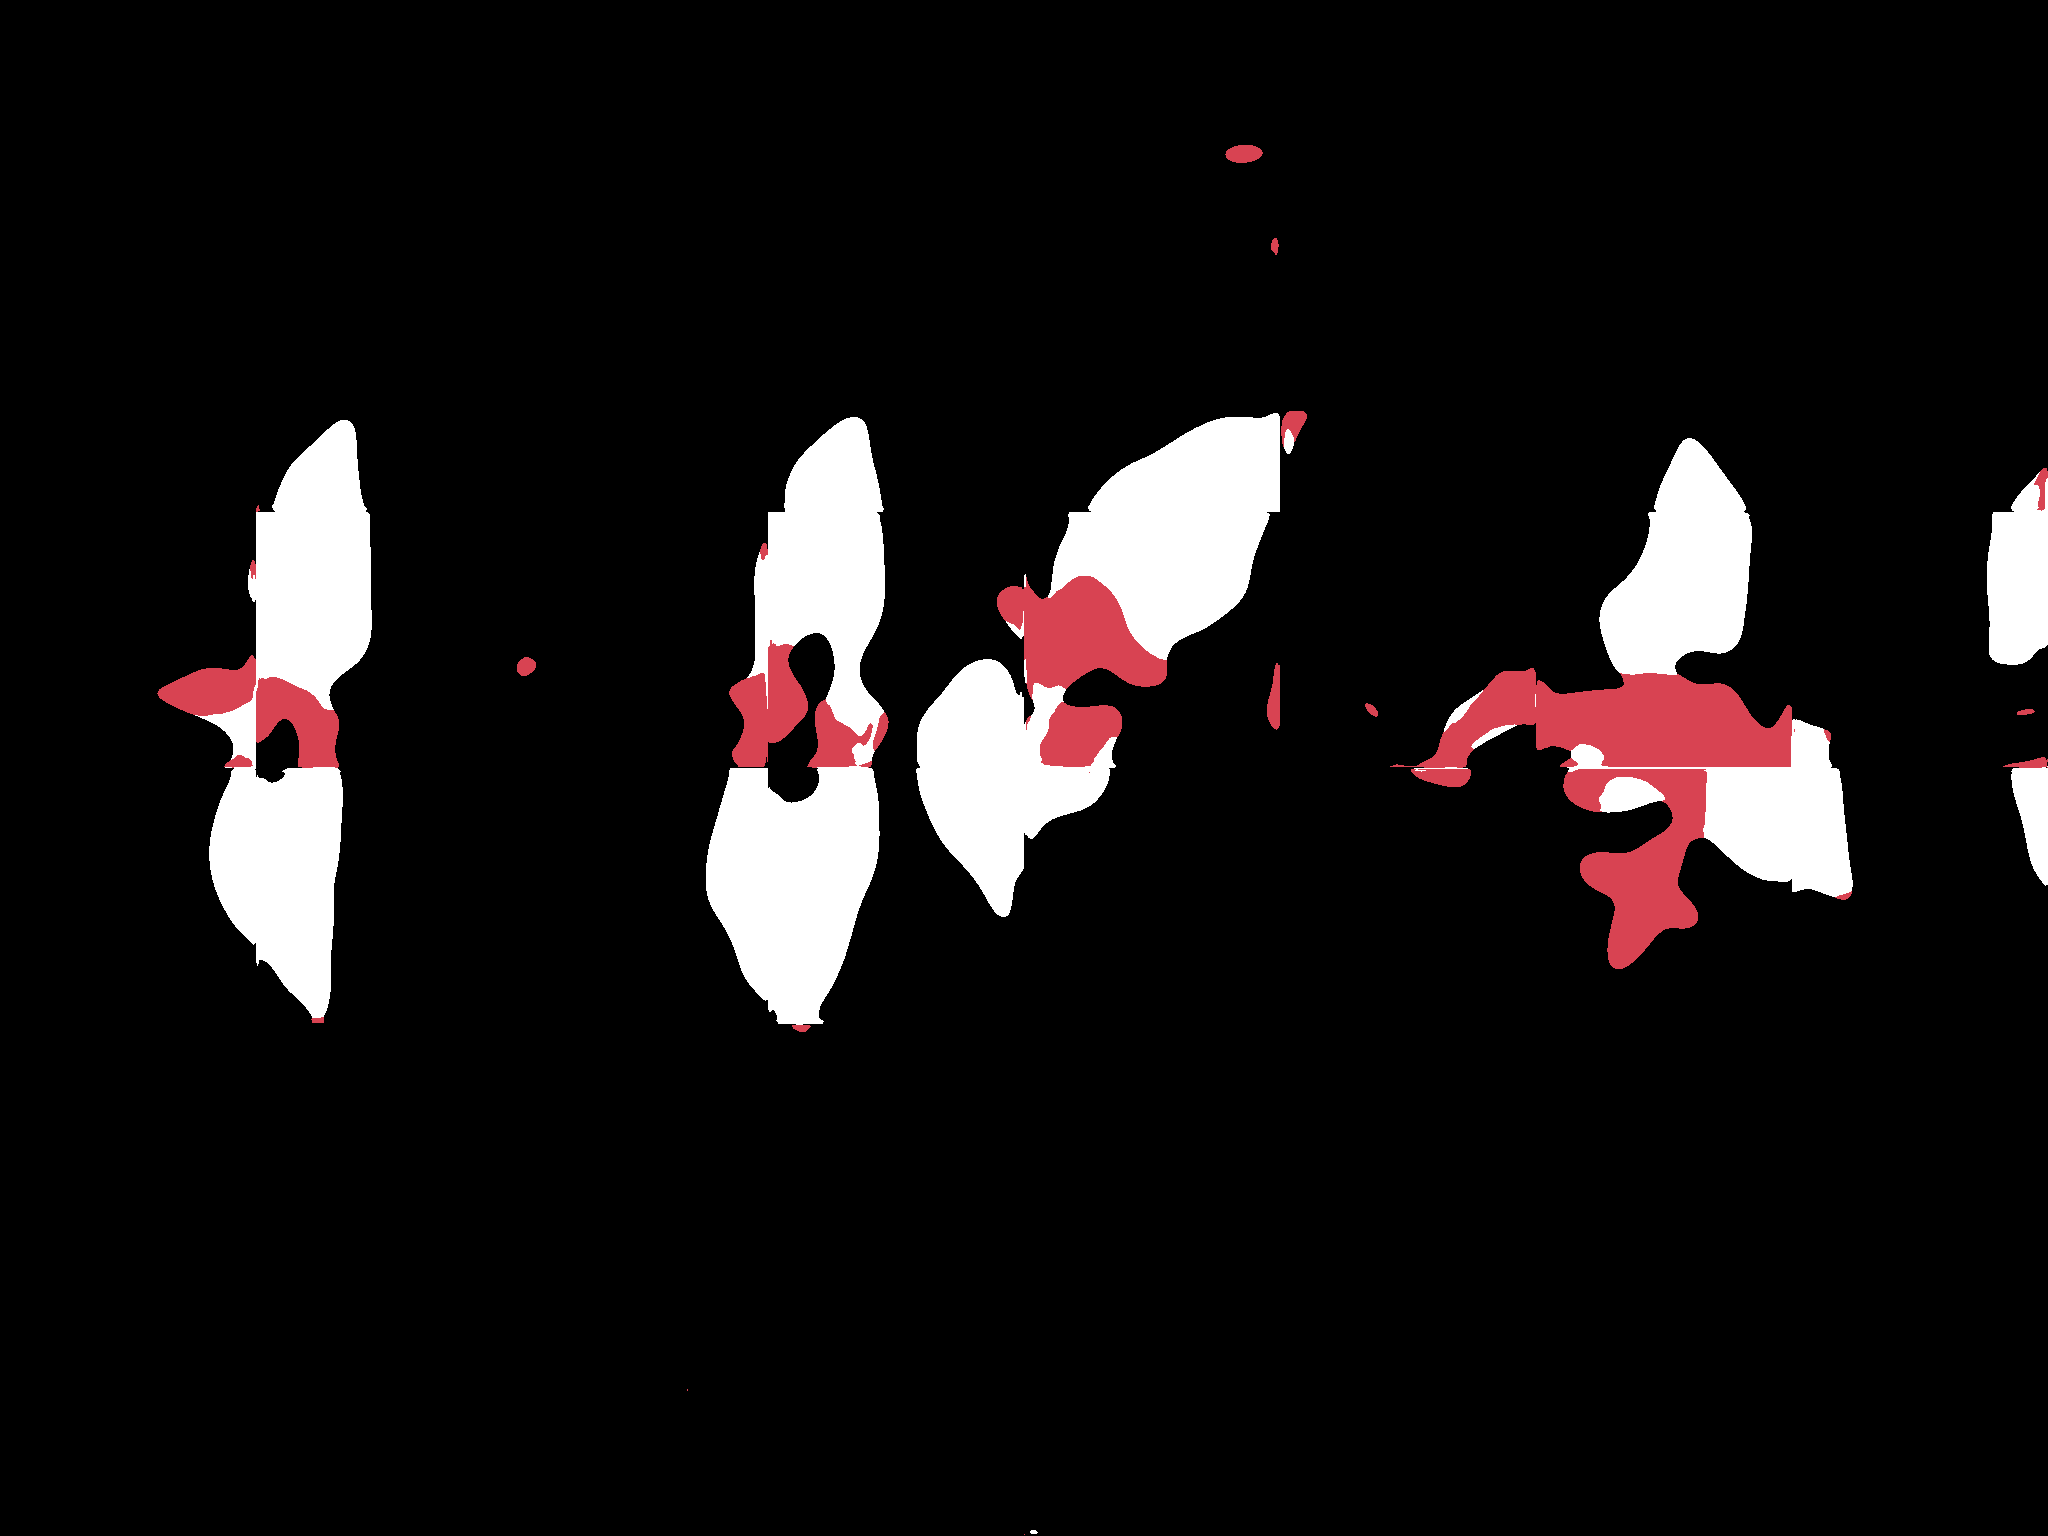

In [ ]:
def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

decode = True
if decode:

    with open('submission.json', 'r') as f:
        submission_dict = json.load(f)

    img_name = 'Bipbip_haricot_im_00211'
    img_shape = submission_dict[img_name]['shape']

    rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
    rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

    
    crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
    weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

    reconstructed_mask = crop_mask + (weed_mask * 2)
    reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
    reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
    reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

    reconstructed_rgb_img = Image.fromarray(
        np.uint8(reconstructed_rgb_arr))
    
    reconstructed_rgb_img